In [16]:
## Step 1: Import Libraries
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

In [17]:
import matplotlib.pyplot as plt

In [18]:
## Step 2: Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [19]:
## Step 3: Scaled Dot-Product Attention
def scaled_dot_product_attention(query, key, value, mask=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    attn = torch.softmax(scores, dim=-1)
    output = torch.matmul(attn, value)
    return output, attn

In [20]:
## Step 4: Multi-Head Attention Layer
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        
        def transform(x, linear):
            x = linear(x)
            x = x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
            return x

        q, k, v = transform(q, self.q_linear), transform(k, self.k_linear), transform(v, self.v_linear)

        scores, attn = scaled_dot_product_attention(q, k, v, mask)
        scores = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)

        return self.out(scores)

In [21]:
## Step 5: Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

In [22]:
## Step 6: Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x2 = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
        x = self.norm2(x2 + self.dropout(self.ff(x2)))
        return x

In [23]:
## Step 7: Encoder
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, max_len=5000):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, src, mask=None):
        x = self.embed(src)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [24]:
## Step 8: Mini Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_layers=2, num_heads=8, d_ff=2048):
        super().__init__()
        self.encoder = Encoder(vocab_size, d_model, num_layers, num_heads, d_ff)
        self.decoder = nn.Linear(d_model, vocab_size)

    def forward(self, src, mask=None):
        enc_output = self.encoder(src, mask)
        return self.decoder(enc_output)

In [25]:
## Step 9: Testing the Model
# Dummy input (batch_size=2, seq_len=10)
sample_input = torch.randint(0, 100, (2, 10))

model = TransformerModel(vocab_size=100)
output = model(sample_input)

print("Input shape:", sample_input.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 10])
Output shape: torch.Size([2, 10, 100])


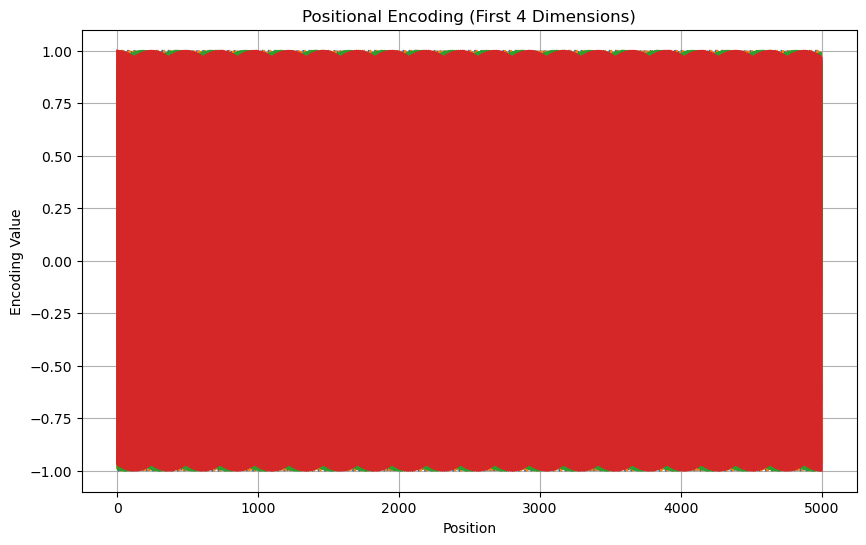

In [26]:
## Step 10: Visualizing Positional Encoding

import matplotlib.pyplot as plt

# Define PositionalEncoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

# Visualize positional encoding
plt.figure(figsize=(10, 6))
pe = PositionalEncoding(512).pe[0].detach().numpy()
plt.plot(pe[:, :4])  # Plot the first 4 dimensions
plt.title("Positional Encoding (First 4 Dimensions)")
plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.grid(True)
plt.show()
